## Calidad de vinos (Clasificacion multiclase)

### Importamos librerias necesarias

In [78]:
import sys;
assert sys.version_info >= (3, 5);
import sklearn;
assert sklearn.__version__ >= "0.20";
from sklearn.svm import SVC;
from sklearn.linear_model import SGDClassifier
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier;
from sklearn.ensemble import RandomForestClassifier;
from sklearn.naive_bayes import GaussianNB 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict;
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix;
from sklearn.metrics import ConfusionMatrixDisplay;
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve;
from sklearn.metrics import roc_auc_score;
from sklearn.utils import resample
import numpy as np;
import pandas as pd
from pandas.plotting import scatter_matrix
import xgboost as xgb 
import os;
import matplotlib as mpl;
import seaborn as sns;
import matplotlib.pyplot as plt;
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
mpl.rc('axes',  labelsize=14);
mpl.rc('xtick', labelsize=12);
mpl.rc('ytick', labelsize=12);



### Primer contacto con los datos

In [79]:
wines_origen = pd.read_csv("./datasets/winequality-red.csv")
wines_origen.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [80]:
wines_origen.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


In [81]:
wines_origen.isna().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

In [82]:
wines_origen[wines_origen.duplicated()].value_counts('quality')

quality
5    104
6    103
7     32
8      1
dtype: int64

- No hay valores nulos.
- No tenemos ninguna columna categorica.
- No tenemos valores NaN.
- Hay valores duplicados, los borraremos para intentar evitar un sobreajuste de los modelos a los datos.

In [83]:
wines = wines_origen.drop_duplicates()
print(f"Valores duplicados restantes: {wines.duplicated().sum()}")
wines["quality"].value_counts()

Valores duplicados restantes: 0


5    577
6    535
7    167
4     53
8     17
3     10
Name: quality, dtype: int64

- En la siguiente grafica vemos que la calidad de los vinos se concentra en los valores 5 y 6. 


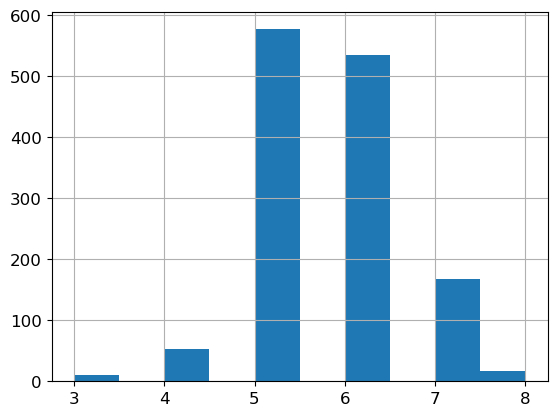

In [84]:
wines['quality'].hist();

In [85]:
wines['quality'].value_counts()

5    577
6    535
7    167
4     53
8     17
3     10
Name: quality, dtype: int64

- Como las 6 calidades de vino que tenemos estan desbalanceadas

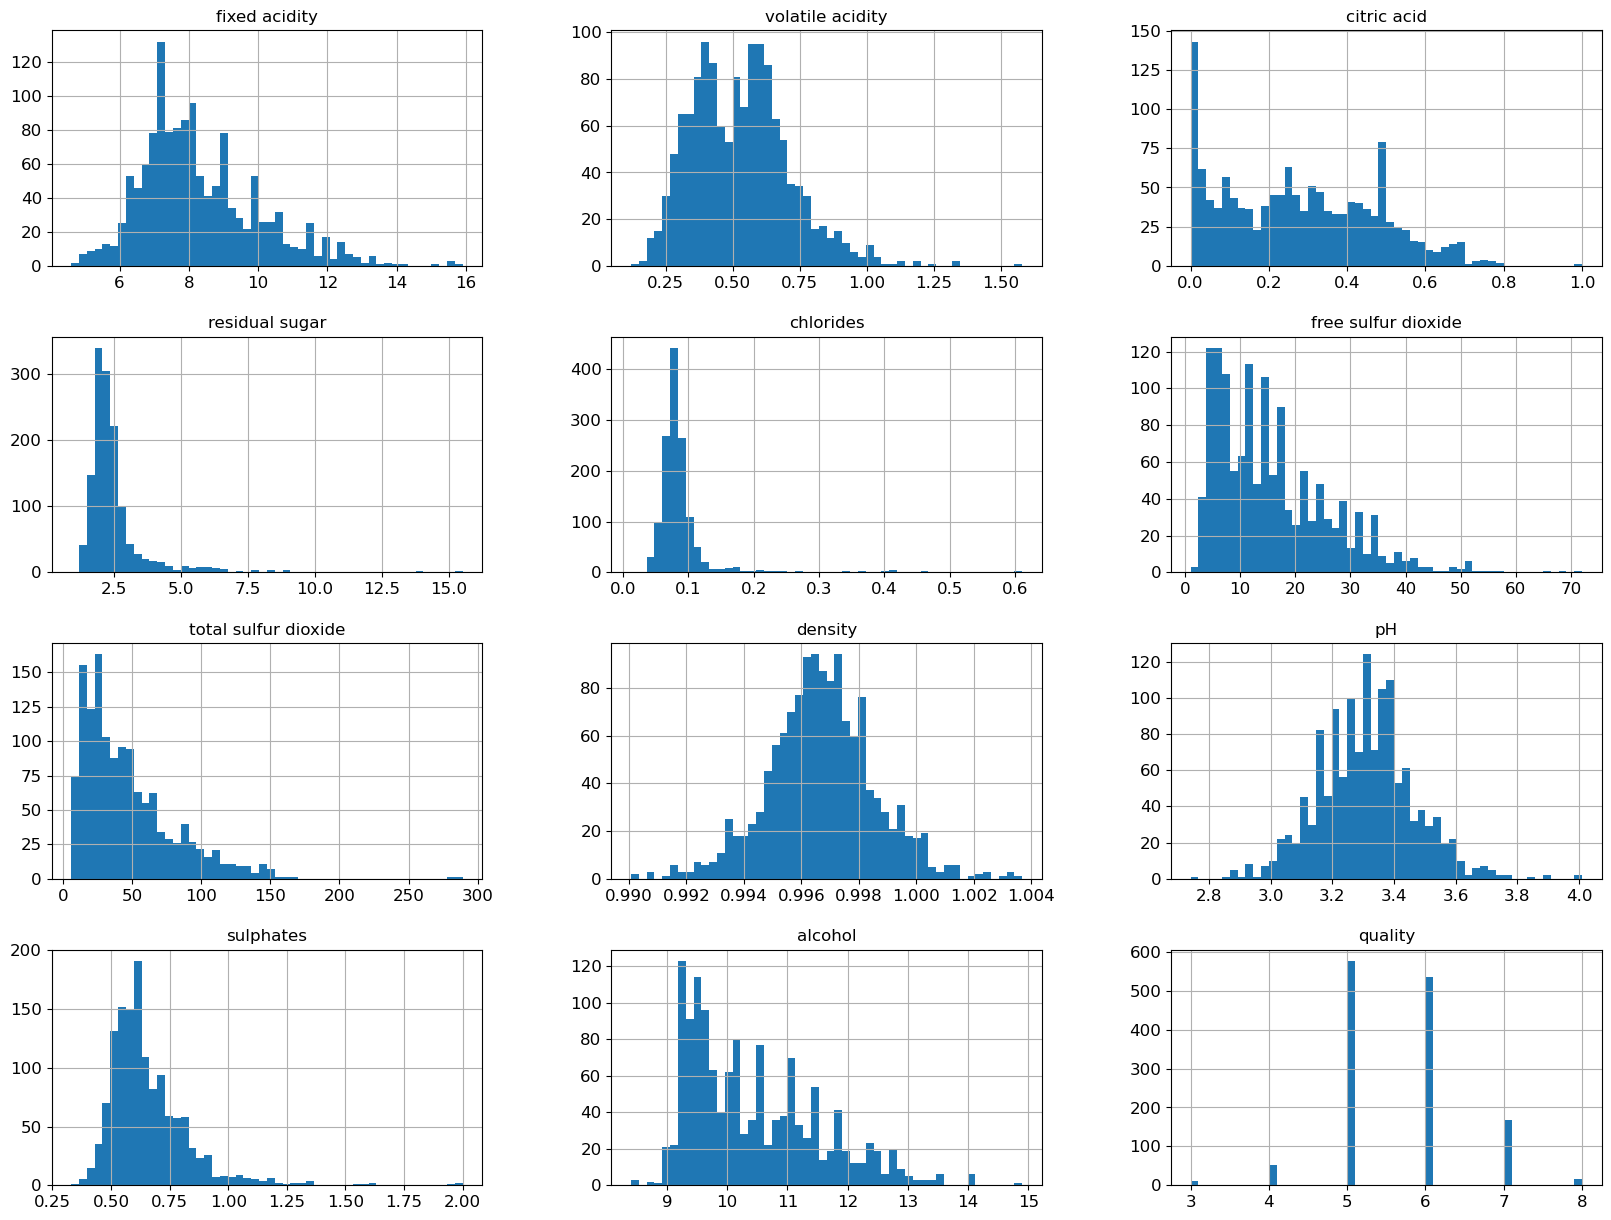

In [86]:
wines.hist(bins=50, figsize=(20,15)) # Histograma
plt.show()

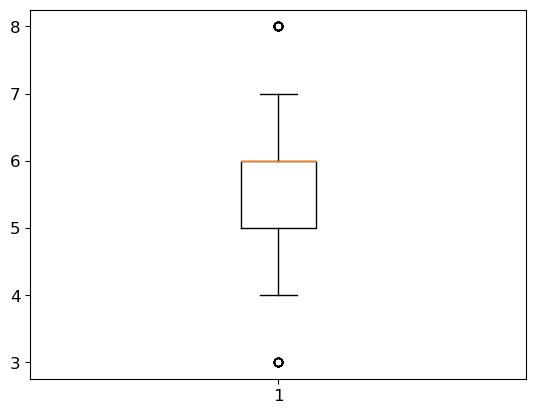

In [87]:
plt.boxplot(wines['quality'])
plt.show()

### Buscando correlaciones
- Buscaremos las correlaciones respecto a la variable 'quality'. Las que mas se acerquen a 1 estaran mas relacionadas on la calidad y las que mas se acerquen a -1 estaran mas relacionadas con la 'mala calidad'. Las que se acerquen mas a 0 no tendran a penas relacion alguna con la calidad.

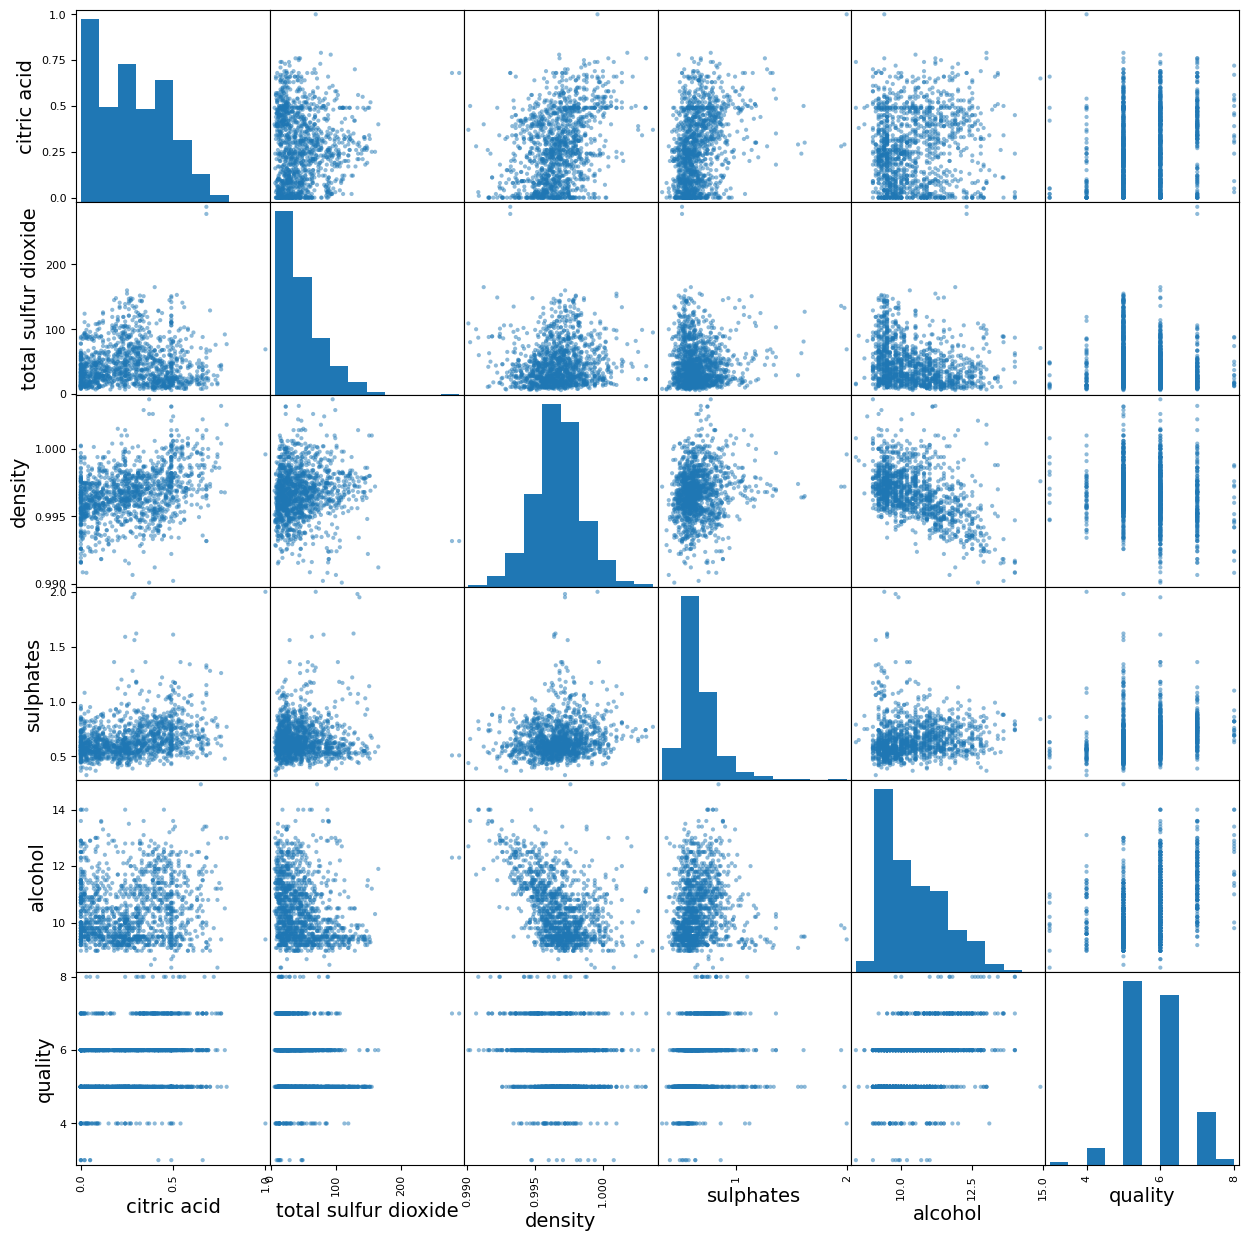

In [88]:
attributes = ['citric acid', 'total sulfur dioxide', 'density',
              'sulphates', 'alcohol', 'quality']


scatter_matrix(wines[attributes], figsize=(15, 15));

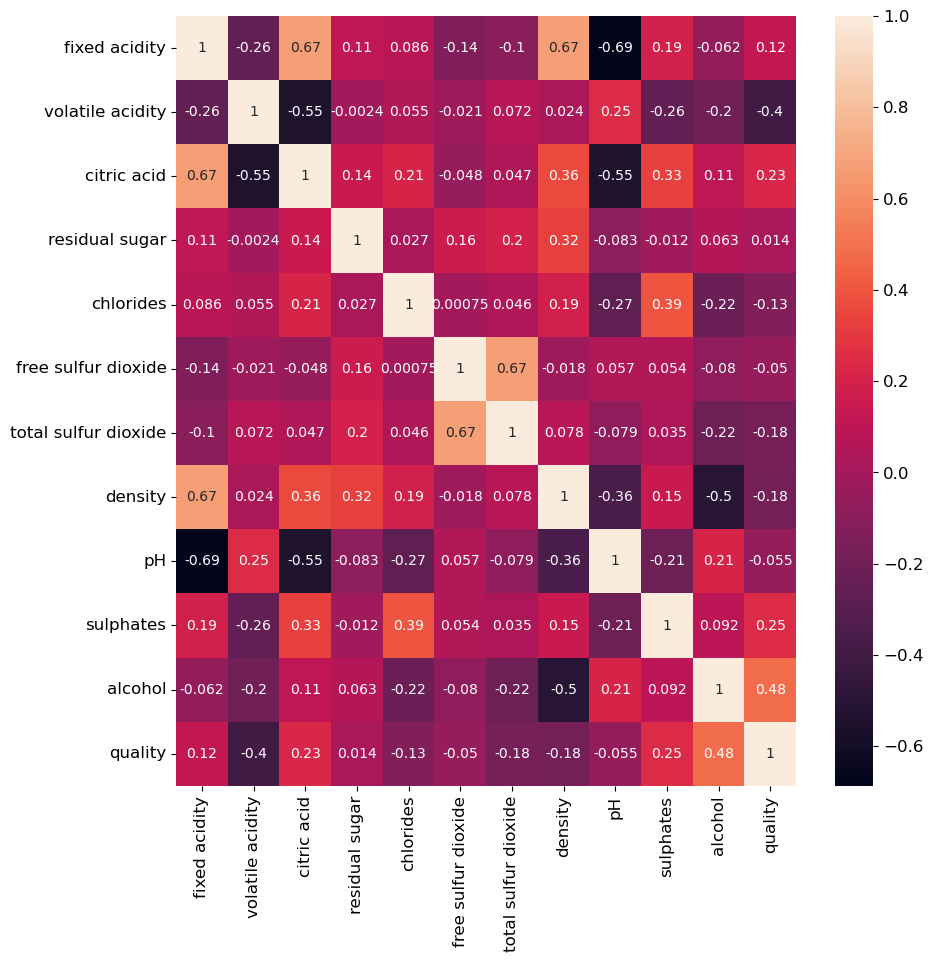

In [89]:
fig, axis= plt.subplots(figsize=(10,10))
sns.heatmap(wines.corr(), annot=True, ax=axis);

##### No hay grandes correlaciones entre la calidad y las demas columnas, pero si es destacable las que hay con:
- Alcoholes: 48.03%
- Acidez volatil -39.52%

In [90]:
corr_matrix = wines.corr();


In [91]:
corr_matrix["quality"].sort_values(ascending=False)

quality                 1.000000
alcohol                 0.480343
sulphates               0.248835
citric acid             0.228057
fixed acidity           0.119024
residual sugar          0.013640
free sulfur dioxide    -0.050463
pH                     -0.055245
chlorides              -0.130988
total sulfur dioxide   -0.177855
density                -0.184252
volatile acidity       -0.395214
Name: quality, dtype: float64

### Separando datos de entreno y validacion

- Separamos los datos de entrenamiento y validacion. Utilizamos un 20% del dataset para los datos de validacion, aunque en algunos casos es posible usar el 50%, el 30%...

In [92]:
X_train, X_test = train_test_split(wines, test_size=0.20, random_state=42)
len(X_train), len(X_test)

(1087, 272)

- Guardamos en una variable las columnas de las etiquetas y la borramos de la variable de datos de entrenamiento

In [93]:
y_train = X_train["quality"].copy()
X_train = X_train.copy().drop("quality", axis=1)


- Hacemos lo mismo con los datos de validacion

In [94]:
y_test = X_test["quality"].copy()
X_test = X_test.copy().drop("quality", axis=1)

- Ademas guardamos un muestra en una variable para poder obserar las predicciones mas comodamente.

In [95]:
some_data = X_test.sample(3)

### Entrenando modelos

#### *SGDClassifier*:    Se basa en el descenso del gradiente estocastico. Esto lo que proporciona es la minimizacion de la funcion de perdida entre las clases predichas por el clasificador y las clases reales de los datos de entrenamiento.

In [96]:
sgd_clf = SGDClassifier(loss= 'log',  random_state=42)
sgd_clf.fit(X_train, y_train)

SGDClassifier(loss='log', random_state=42)

- Con la siguiente linea podemos ver el total de clases contra las que se clasifica.

In [97]:
sgd_clf.classes_

array([3, 4, 5, 6, 7, 8], dtype=int64)

- Imprimimos las predicciones del set de validacion y vemos que nos devuelve un array de numpy. Este array tiene la misma longitud que el set de valores reales de validacion y cada posicion indica la clase de calidad a la que pertenece.

In [98]:
sgd_y_pred = sgd_clf.predict(X_test)
print(len(sgd_y_pred), len(y_test))
sgd_y_pred

272 272


array([5, 5, 7, 5, 6, 7, 5, 5, 3, 6, 7, 5, 5, 5, 7, 5, 7, 5, 5, 5, 5, 6,
       5, 5, 5, 5, 5, 5, 5, 6, 6, 7, 5, 5, 6, 7, 5, 6, 5, 5, 5, 5, 6, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 5, 5, 5, 5, 7, 5, 5, 5, 6, 5, 5,
       5, 5, 5, 3, 5, 5, 5, 5, 6, 5, 5, 5, 5, 5, 7, 5, 5, 5, 5, 7, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 6, 5, 6, 5, 5, 5, 5, 5, 6, 5, 5, 6, 7, 7,
       6, 6, 5, 5, 5, 5, 5, 5, 5, 5, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 7, 6, 6, 5, 5, 5, 7, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6,
       5, 6, 5, 5, 7, 7, 5, 5, 6, 3, 5, 7, 5, 5, 7, 5, 5, 5, 7, 5, 7, 5,
       5, 5, 5, 7, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 7, 5, 5, 5, 7, 5,
       7, 6, 5, 7, 5, 7, 5, 7, 5, 5, 5, 5, 7, 7, 5, 5, 5, 5, 7, 7, 5, 7,
       5, 5, 5, 5, 5, 5, 7, 5, 5, 5, 5, 5, 7, 5, 7, 7, 6, 5, 5, 5, 5, 5,
       5, 5, 7, 5, 5, 6, 6, 7, 5, 5, 5, 6, 6, 5, 5, 3, 5, 6, 5, 5, 5, 5,
       5, 5, 5, 7, 5, 5, 5, 5], dtype=int64)

- Volvemos a predecir las etiquetas de un set de 3 instancias

In [99]:
sgd_y_pred_muestra = sgd_clf.predict(some_data)
sgd_y_pred_muestra

array([5, 5, 5], dtype=int64)

- Recordamos que las clases/etiquetas qe estamos utilizando para la clasificacion son [3,4,5,6,7,8]
- Utilizando la funcion decision_function() podemos observar la confianza con la que el modelo realizo las predicciones. El valor mas positivo (o menos negativo) sera el tomado como correcto.
- Si hay dos valores positivos cercanos, podriamos deducir que estamos ante un falso positivo.

In [100]:
sgd_clf.decision_function(some_data)

array([[ -197.26838663,  -402.94954231,   -26.49209256,  -119.49602666,
         -225.37835647,  -289.58326017],
       [ -570.425164  , -1381.32499739,    82.24591116,  -456.28251918,
         -465.37718093,  -969.71959267],
       [-1025.18570965, -1718.6295706 ,   430.70212177,  -693.2055466 ,
         -744.8969833 , -1071.5469644 ]])

- Vamos a hacer una prediccion con los datos de entrenamiento. Para ello utilizaremos la validacion cruzada, dividieno los datos en 3 subconjuntos. Entre estos subconjuntos, uno sera para evaluar y el resto para entrenar. Todo esto se hará las veces suficientes para que cada subconjunto haya evaluado una vez.

In [101]:
pred_sgd = cross_val_predict(sgd_clf, X_train, y_train, cv=3)
f"Precisiones: {pred_sgd}"

'Precisiones: [7 5 5 ... 5 5 5]'

1. *Precision*: El porcentaje de aciertos que verdaderamente lo son. En otras palabras, la capacidad del modelo de limitar los falsos positivos.  
   **Precision = TP / (TP + FP)** 
2. *Sensibilidad* (recall): El porcentaje de aciertos que fueron identificados por el modelo.  
   **Recall = TP / (TP + FN)**
3. *F1-score*: Es la media armonica (tasa de variacion) de *recall* y *precision*.  
   **F1-score = 2 * (recall * precision) / (recall + precision)**

In [102]:
precision = precision_score(y_train, pred_sgd, average=None)
recall = recall_score(y_train, pred_sgd, average=None)
f1 = f1_score(y_train, pred_sgd, average=None)

print(f"Precision: {precision}\nrecall: {recall}\nf1-score: {f1}")

Precision: [0.         0.         0.48818898 0.5        0.36054422 0.        ]
recall: [0.         0.         0.94967177 0.04861111 0.38970588 0.        ]
f1-score: [0.         0.         0.6448737  0.08860759 0.3745583  0.        ]


c:\Users\Josemolamazo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [103]:
precision = precision_score(y_test, sgd_y_pred, average=None)
recall = recall_score(y_test, sgd_y_pred, average=None)
f1 = f1_score(y_test, sgd_y_pred, average=None)

print(f"Precision: {precision}\nrecall: {recall}\nf1-score: {f1}")

Precision: [0.         0.         0.56565657 0.4516129  0.46153846 0.        ]
recall: [0.         0.         0.93333333 0.13592233 0.58064516 0.        ]
f1-score: [0.         0.         0.70440252 0.20895522 0.51428571 0.        ]


c:\Users\Josemolamazo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


- Podemos observar en las dos celdas anteriores que las puntuaciones de precision, recall y f1 para las calidades 3,4 y 8 son 0. Esto es debido a que hay muy pocos valores para esas calidades en todo el dataset. Las demas calidades tienen puntuaciones pero la mayoria son muy bajas, a excepcion de la sensibilidad con los vinos de calidad 5.

#### *SVC*: *Support Vector Machine Classifier* es un clasificador binario (por defecto) que se basa en separar ambas clases por medio de un hiperplano. En el contexto de la clasificacion multiclase, se debera implementar junto con otro clasificador. Los clasificadores que lo pueden acompañar son:
1. *OneVsRestClassifier*
2. *OneVsOneClassifier*

In [104]:
svm_clf = SVC(gamma="auto", random_state=42);

##### *OneVsRestClassifier*: Este clasificador multiclase que entrena un clasificador binario por cada clase, usando los datos de una clase como positivos y los de las demas clases como negativos.

In [105]:
ovr_clf = OneVsRestClassifier(svm_clf);
ovr_clf.fit(X_train, y_train);
ovr_y_pred = ovr_clf.predict(X_test)
ovr_y_pred

array([6, 6, 6, 5, 6, 7, 6, 5, 5, 5, 6, 5, 6, 5, 5, 5, 6, 5, 5, 5, 5, 5,
       5, 5, 6, 5, 6, 5, 6, 5, 7, 6, 6, 5, 6, 6, 5, 5, 6, 6, 5, 5, 6, 5,
       6, 7, 5, 5, 5, 7, 5, 5, 7, 6, 7, 5, 5, 5, 5, 5, 5, 6, 5, 6, 6, 6,
       5, 6, 6, 5, 5, 5, 6, 5, 6, 5, 5, 6, 5, 6, 6, 5, 5, 6, 5, 6, 6, 5,
       6, 5, 6, 6, 5, 6, 6, 5, 7, 5, 7, 6, 5, 6, 5, 5, 5, 6, 6, 6, 7, 6,
       6, 6, 7, 6, 5, 5, 6, 5, 5, 5, 4, 5, 5, 5, 6, 5, 6, 5, 5, 5, 6, 5,
       5, 5, 5, 5, 6, 6, 6, 5, 5, 5, 7, 6, 6, 5, 6, 5, 6, 5, 5, 6, 5, 4,
       5, 6, 5, 5, 6, 5, 5, 5, 5, 6, 5, 7, 5, 5, 5, 7, 5, 6, 6, 5, 6, 6,
       6, 5, 5, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 5, 6, 6, 5, 5, 7, 5,
       6, 6, 5, 6, 5, 6, 5, 7, 5, 6, 6, 5, 6, 5, 6, 5, 6, 5, 7, 6, 5, 6,
       5, 6, 5, 6, 6, 6, 7, 5, 5, 5, 5, 6, 7, 5, 6, 6, 6, 6, 5, 5, 6, 5,
       5, 5, 7, 5, 5, 5, 5, 7, 5, 5, 5, 6, 6, 5, 5, 5, 5, 5, 5, 6, 6, 5,
       5, 5, 6, 7, 6, 6, 6, 6], dtype=int64)

In [106]:
pred_ovr = cross_val_predict(ovr_clf, X_train, y_train, cv=3)
f"Precisiones: {pred_ovr}"

'Precisiones: [7 6 5 ... 5 6 6]'

In [107]:
precision = precision_score(y_train, pred_ovr, average=None)
recall = recall_score(y_train, pred_ovr, average=None)
f1 = f1_score(y_train, pred_ovr, average=None)

print(f"Precision: {precision}\nrecall: {recall}\nf1-score: {f1}")

Precision: [0.         0.         0.54438861 0.47303922 0.39473684 0.        ]
recall: [0.         0.         0.71115974 0.44675926 0.22058824 0.        ]
f1-score: [0.         0.         0.61669829 0.45952381 0.28301887 0.        ]


c:\Users\Josemolamazo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [108]:
precision = precision_score(y_test, ovr_y_pred, average=None)
recall = recall_score(y_test, ovr_y_pred, average=None)
f1 = f1_score(y_test, ovr_y_pred, average=None)

print(f"Precision: {precision}\nrecall: {recall}\nf1-score: {f1}")

Precision: [0.         0.5        0.55479452 0.42718447 0.38095238 0.        ]
recall: [0.         0.09090909 0.675      0.42718447 0.25806452 0.        ]
f1-score: [0.         0.15384615 0.60902256 0.42718447 0.30769231 0.        ]


c:\Users\Josemolamazo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


- Las puntuaciones del SVC con los datos de entrenamiento no mejoran con respecto al SGD. Sin embargo con los datos de validacion empieza a clasificar vinos de calidad 4. De todos modos, no es un buen modelo por que las puntuaciones mas altas son la de la calidad 5 y no superan el 70%.

##### *OneVsOneClassifier*: Este clasificador entrenara las calidades de los vinos entrenando por cada par de claves.

In [109]:
ovo_clf = OneVsOneClassifier(svm_clf);
ovo_clf.fit(X_train, y_train);
ovo_y_pred = ovo_clf.predict(X_test)
ovo_y_pred

array([6, 6, 6, 5, 6, 7, 6, 5, 5, 6, 6, 5, 6, 5, 6, 5, 6, 5, 6, 5, 5, 5,
       5, 5, 6, 5, 6, 5, 6, 5, 6, 6, 6, 5, 6, 6, 5, 5, 6, 6, 6, 5, 6, 5,
       6, 6, 5, 5, 5, 5, 5, 5, 6, 6, 7, 5, 6, 5, 5, 5, 5, 6, 5, 6, 6, 6,
       5, 6, 6, 5, 5, 5, 6, 5, 6, 5, 5, 6, 5, 6, 6, 5, 5, 6, 5, 6, 6, 5,
       6, 5, 6, 6, 6, 6, 6, 5, 7, 6, 6, 6, 5, 6, 5, 5, 6, 6, 6, 6, 6, 6,
       6, 6, 5, 6, 5, 5, 6, 5, 5, 5, 6, 5, 5, 5, 6, 6, 6, 5, 5, 5, 6, 5,
       5, 5, 5, 5, 7, 6, 6, 5, 5, 5, 7, 6, 6, 6, 6, 5, 6, 5, 5, 6, 5, 6,
       5, 6, 5, 5, 6, 7, 5, 5, 5, 6, 5, 6, 5, 5, 5, 6, 5, 6, 6, 5, 6, 6,
       6, 5, 5, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 5, 6, 6, 5, 5, 7, 5,
       6, 6, 5, 6, 5, 6, 5, 7, 5, 6, 6, 5, 6, 5, 6, 5, 6, 5, 6, 6, 5, 6,
       5, 6, 5, 6, 6, 6, 7, 5, 5, 5, 5, 6, 7, 5, 6, 6, 6, 6, 5, 5, 6, 6,
       5, 5, 7, 5, 5, 5, 5, 7, 5, 5, 5, 6, 6, 5, 5, 5, 5, 6, 5, 6, 6, 6,
       5, 5, 6, 7, 6, 6, 6, 6], dtype=int64)

In [110]:
pred_ovo = cross_val_predict(ovo_clf, X_train, y_train, cv=3)
f"Precisiones: {pred_ovo}"

'Precisiones: [7 6 6 ... 6 6 6]'

In [111]:
precision = precision_score(y_train, pred_ovo, average=None)
recall = recall_score(y_train, pred_ovo, average=None)
f1 = f1_score(y_train, pred_ovo, average=None)

print(f"Precision: {precision}\nrecall: {recall}\nf1-score: {f1}")

Precision: [0.         0.         0.5631769  0.48185484 0.54054054 0.        ]
recall: [0.         0.         0.68271335 0.55324074 0.14705882 0.        ]
f1-score: [0.         0.         0.61721068 0.51508621 0.23121387 0.        ]


c:\Users\Josemolamazo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [112]:
precision = precision_score(y_test, ovo_y_pred, average=None)
recall = recall_score(y_test, ovo_y_pred, average=None)
f1 = f1_score(y_test, ovo_y_pred, average=None)

print(f"Precision: {precision}\nrecall: {recall}\nf1-score: {f1}")

Precision: [0.         0.         0.56716418 0.44       0.61538462 0.        ]
recall: [0.         0.         0.63333333 0.53398058 0.25806452 0.        ]
f1-score: [0.         0.         0.5984252  0.48245614 0.36363636 0.        ]


c:\Users\Josemolamazo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


- Utilizando un OneVsOneClassifier volvemos a tener unicamente puntuaciones de los vinos de calidad 5, 6 y 7. Otra vez son puntuaciones bajas.

#### *RandomForestClassifier*: Es un clasificador que se basa en un conjunto de arboles de decision que entrenan submuestras aleatorias.

In [113]:
forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
forest_clf.fit(X_train, y_train)
forest_y_pred = forest_clf.predict(X_test)
forest_y_pred

array([5, 6, 7, 5, 6, 7, 6, 5, 6, 6, 6, 6, 6, 6, 6, 5, 6, 5, 5, 6, 5, 6,
       5, 5, 6, 5, 6, 5, 5, 6, 6, 6, 6, 5, 5, 6, 5, 6, 5, 6, 5, 6, 6, 5,
       5, 5, 5, 5, 5, 6, 6, 6, 6, 5, 6, 5, 6, 5, 5, 5, 5, 6, 5, 6, 5, 6,
       5, 5, 5, 7, 5, 8, 6, 6, 6, 5, 5, 5, 5, 5, 6, 6, 5, 5, 5, 6, 5, 5,
       6, 6, 6, 5, 5, 5, 6, 6, 5, 7, 6, 5, 5, 5, 5, 6, 6, 5, 6, 6, 7, 6,
       6, 6, 5, 5, 5, 6, 5, 5, 6, 6, 5, 5, 5, 6, 6, 5, 5, 5, 5, 5, 5, 5,
       6, 6, 5, 5, 7, 6, 6, 5, 5, 5, 7, 5, 6, 6, 6, 6, 6, 6, 5, 6, 5, 5,
       5, 6, 6, 5, 6, 7, 6, 5, 5, 6, 5, 7, 5, 5, 6, 6, 7, 6, 5, 6, 7, 6,
       5, 5, 5, 6, 5, 6, 5, 5, 5, 6, 5, 5, 5, 6, 6, 5, 7, 5, 5, 6, 6, 5,
       6, 6, 5, 6, 5, 7, 5, 6, 5, 5, 5, 6, 6, 6, 6, 5, 6, 6, 7, 7, 5, 6,
       5, 6, 5, 6, 5, 5, 6, 6, 6, 5, 6, 6, 6, 5, 6, 8, 6, 6, 5, 5, 5, 6,
       5, 6, 6, 5, 5, 6, 6, 7, 6, 5, 7, 6, 6, 6, 5, 5, 6, 6, 7, 5, 5, 5,
       6, 6, 6, 7, 5, 6, 6, 5], dtype=int64)

- Observamos la lista de probabilidades que el *RandomForestClassifier* asigno a cada instancia de cada clase. En la primera lista, por ejemplo, resalta que es mas probable que el vino sea de calidad 5. Aunque hay un pequeña posibilidad de que sea de tipo 4 o 6.

In [114]:
forest_clf.predict_proba(X_test)

array([[0.  , 0.07, 0.82, 0.11, 0.  , 0.  ],
       [0.  , 0.03, 0.23, 0.67, 0.07, 0.  ],
       [0.  , 0.01, 0.1 , 0.41, 0.43, 0.05],
       ...,
       [0.  , 0.01, 0.21, 0.53, 0.24, 0.01],
       [0.  , 0.04, 0.14, 0.63, 0.09, 0.1 ],
       [0.  , 0.12, 0.51, 0.37, 0.  , 0.  ]])

In [115]:
pred_fst = cross_val_predict(forest_clf, X_train, y_train, cv=3)
f"Precisiones: {pred_fst}"

'Precisiones: [7 5 5 ... 5 6 6]'

In [116]:
precision = precision_score(y_train, forest_y_pred, average=None)
recall = recall_score(y_train, forest_y_pred, average=None)
f1 = f1_score(y_train, forest_y_pred, average=None)

print(f"Precision: {precision}\nrecall: {recall}\nf1-score: {f1}")

ValueError: Found input variables with inconsistent numbers of samples: [1087, 272]

In [ ]:
precision = precision_score(y_test, forest_y_pred, average=None)
recall = recall_score(y_test, forest_y_pred, average=None)
f1 = f1_score(y_test, forest_y_pred, average=None)

print(f"Precision: {precision}\nrecall: {recall}\nf1-score: {f1}")

Precision: [0.         0.         0.703125   0.59349593 0.78947368 0.        ]
recall: [0.         0.         0.75       0.70873786 0.48387097 0.        ]
f1-score: [0.         0.         0.72580645 0.6460177  0.6        0.        ]


c:\Users\Josemolamazo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


- Este modelo tiene las mejores puntuaciones para la calidad 5 con respecto a los demas. Sin embargo no tiene niguna puntuacion de las calidad 3,4 y 8.

##### *GaussianNB*: El Naive Bayes Classifier es un clasifiador probabilistico basado en el teorema de bayes.

In [ ]:
bayes_clf = GaussianNB()  
bayes_clf.fit(X_train, y_train)
bayes_y_pred = bayes_clf.predict(X_test) 
bayes_y_pred

array([5, 6, 7, 6, 4, 7, 6, 5, 6, 6, 7, 6, 6, 6, 7, 5, 7, 5, 5, 6, 5, 6,
       5, 5, 6, 5, 6, 5, 5, 4, 6, 7, 5, 5, 6, 6, 5, 6, 6, 7, 4, 6, 6, 5,
       5, 5, 5, 5, 5, 6, 4, 7, 6, 6, 7, 5, 5, 5, 5, 7, 5, 6, 5, 6, 6, 6,
       5, 5, 7, 5, 5, 6, 7, 7, 6, 5, 5, 5, 6, 5, 7, 5, 5, 5, 5, 7, 5, 5,
       6, 6, 7, 6, 3, 5, 6, 5, 4, 6, 6, 5, 5, 5, 5, 6, 6, 5, 6, 6, 7, 7,
       6, 5, 5, 5, 5, 5, 6, 5, 6, 7, 5, 5, 5, 6, 6, 6, 5, 5, 5, 5, 5, 6,
       6, 6, 5, 4, 7, 6, 6, 5, 5, 5, 7, 6, 5, 6, 6, 5, 5, 5, 5, 6, 5, 5,
       5, 6, 4, 5, 6, 7, 6, 6, 6, 6, 5, 7, 6, 5, 6, 6, 7, 6, 7, 4, 7, 6,
       4, 5, 5, 7, 5, 6, 4, 6, 5, 6, 5, 5, 5, 6, 5, 5, 7, 5, 5, 5, 7, 6,
       7, 7, 5, 7, 5, 7, 5, 7, 5, 6, 5, 6, 7, 6, 6, 5, 7, 5, 7, 7, 6, 6,
       5, 7, 5, 6, 5, 6, 7, 6, 5, 6, 5, 6, 7, 5, 6, 7, 6, 5, 5, 5, 5, 6,
       5, 5, 7, 5, 5, 6, 6, 7, 6, 5, 6, 6, 6, 7, 5, 5, 6, 6, 5, 6, 5, 4,
       6, 5, 6, 7, 5, 6, 6, 5], dtype=int64)

In [ ]:
pred_bayes = cross_val_predict(bayes_clf, X_train, y_train, cv=3)
f"Precisiones: {pred_bayes}"

'Precisiones: [7 4 6 ... 6 6 7]'

In [ ]:
precision = precision_score(y_train, pred_bayes, average=None)
recall = recall_score(y_train, pred_bayes, average=None)
f1 = f1_score(y_train, pred_bayes, average=None)

print(f"Precision: {precision}\nrecall: {recall}\nf1-score: {f1}")

Precision: [0.         0.10344828 0.64113786 0.53050398 0.35393258 0.        ]
recall: [0.         0.14285714 0.64113786 0.46296296 0.46323529 0.        ]
f1-score: [0.         0.12       0.64113786 0.49443758 0.40127389 0.        ]


In [ ]:
precision = precision_score(y_test, bayes_y_pred, average=None)
recall = recall_score(y_test, bayes_y_pred, average=None)
f1 = f1_score(y_test, bayes_y_pred, average=None)

print(f"Precision: {precision}\nrecall: {recall}\nf1-score: {f1}")

Precision: [0.         0.18181818 0.66666667 0.53608247 0.43478261 0.        ]
recall: [0.         0.18181818 0.65       0.50485437 0.64516129 0.        ]
f1-score: [0.         0.18181818 0.65822785 0.52       0.51948052 0.        ]


c:\Users\Josemolamazo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


- En el modelo bayesiano guarda puntuaciones de las calidades 4,5,6 y 7 tanto en utilizando el conjunto de entrenamiento como en el de validacion. 

### Analisis del error

- Para analizar el error de los modelos anteriores, utilizaremos las matrices de confusion. Esta sirven para comparar las clases reales contra las clases predichas por los modelos, siendo la diagonal los verdaderos positivos.

In [118]:
y_test_pred = cross_val_predict(sgd_clf, X_test, y_test, cv=3)
cm_sgd = confusion_matrix(y_test, y_test_pred)
cm_sgd 

array([[ 0,  0,  1,  1,  2,  0],
       [ 0,  0,  3,  2,  6,  0],
       [ 0,  0, 36,  8, 76,  0],
       [ 0,  0, 24, 18, 61,  0],
       [ 2,  0,  5,  5, 19,  0],
       [ 0,  0,  0,  1,  2,  0]], dtype=int64)

In [119]:
y_test_pred = cross_val_predict(ovr_clf, X_test, y_test, cv=3)
cm_ovr = confusion_matrix(y_test, y_test_pred)
cm_ovr 

array([[ 0,  0,  3,  1,  0,  0],
       [ 0,  0,  9,  2,  0,  0],
       [ 0,  0, 87, 30,  3,  0],
       [ 0,  1, 64, 31,  7,  0],
       [ 0,  0, 18,  8,  5,  0],
       [ 0,  0,  3,  0,  0,  0]], dtype=int64)

In [120]:
y_test_pred = cross_val_predict(forest_clf, X_test, y_test, cv=3)
cm_forest = confusion_matrix(y_test, y_test_pred)
cm_forest 

array([[ 0,  1,  2,  1,  0,  0],
       [ 0,  0,  8,  3,  0,  0],
       [ 0,  1, 87, 31,  1,  0],
       [ 0,  0, 41, 57,  5,  0],
       [ 0,  0,  2, 21,  8,  0],
       [ 0,  0,  0,  3,  0,  0]], dtype=int64)

In [121]:
y_test_pred = cross_val_predict(bayes_clf, X_test, y_test, cv=3)
cm_bayes = confusion_matrix(y_test, y_test_pred)
cm_bayes 

array([[ 0,  2,  2,  0,  0,  0],
       [ 0,  6,  3,  2,  0,  0],
       [ 0, 15, 57, 44,  4,  0],
       [ 0, 11, 25, 51, 14,  2],
       [ 0,  1,  3, 21,  6,  0],
       [ 0,  0,  0,  3,  0,  0]], dtype=int64)

- Podemos observar que el modelo SGD comete una gran cantidad de fallos prediciendo erroneamente vinos de calidad 7 cuando son de calidad 5 y 6.
- Por otro lado, tambien se equivoca prediciendo vinos de calidad 5 cuando en realidad son de calidad 6.

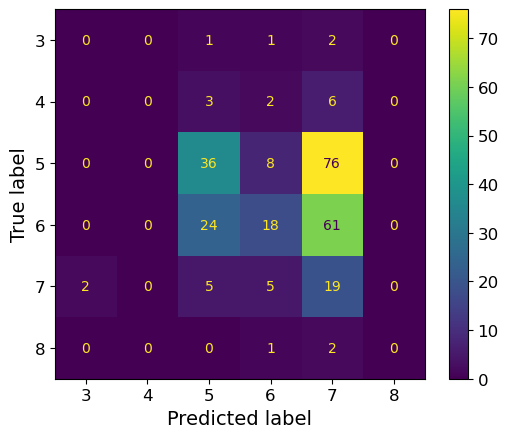

In [122]:
cm_display = ConfusionMatrixDisplay(cm_sgd, display_labels= sgd_clf.classes_)
cm_display.plot()
plt.show()

- La siguiente matriz esta normalizada. Podemos observar el porcentaje de errores por fila, donde destacan los errores de prediccion de calidad 7 en cada una de ellas.

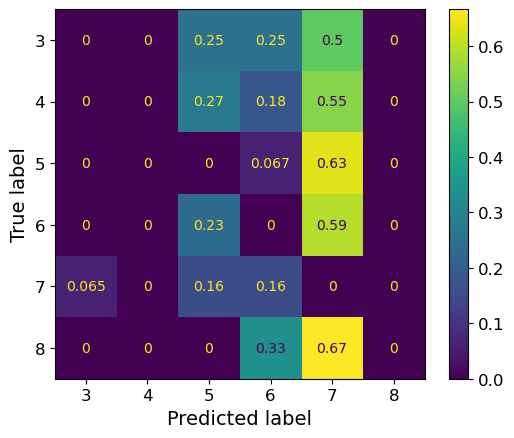

In [123]:
row_sum = cm_sgd.sum(axis=1,keepdims=True)
norm_cm_sgd = cm_sgd / row_sum
np.fill_diagonal(norm_cm_sgd, 0)
cm_display = ConfusionMatrixDisplay(norm_cm_sgd, display_labels= sgd_clf.classes_)
cm_display.plot()
plt.show()

- En el modelo SVC utilizado con OvR se puede apreciar que la calidad 5 posee la mayoria de aciertos, sin embargo contiene muchos fallos.
- Tambien contiene mayor numero de TP que el modelo SGD.

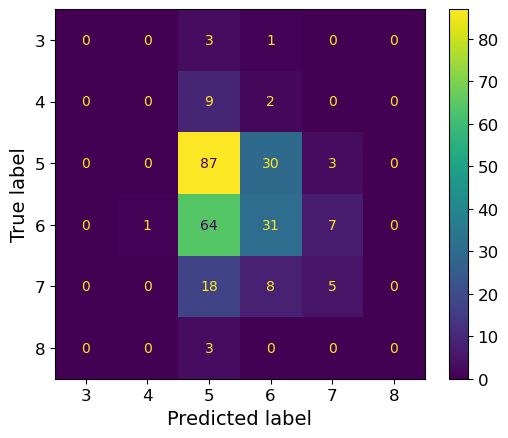

In [124]:
cm_display = ConfusionMatrixDisplay(cm_ovr, display_labels= sgd_clf.classes_)
cm_display.plot()
plt.show()

- En la matriz normalizada del SVC destaca que todas las calidades 8 son predichas como calidades 5. En menor medida sucede con las calidades reales de 3 y 4.

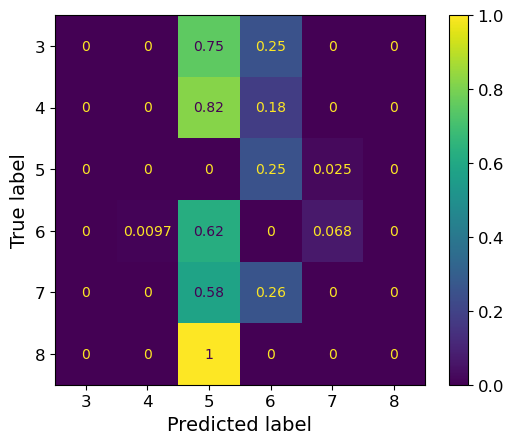

In [131]:
row_sum = cm_ovr.sum(axis=1,keepdims=True)
norm_cm_ovr = cm_ovr / row_sum
np.fill_diagonal(norm_cm_ovr, 0)
cm_display = ConfusionMatrixDisplay(norm_cm_ovr, display_labels= sgd_clf.classes_)
cm_display.plot()
plt.show()

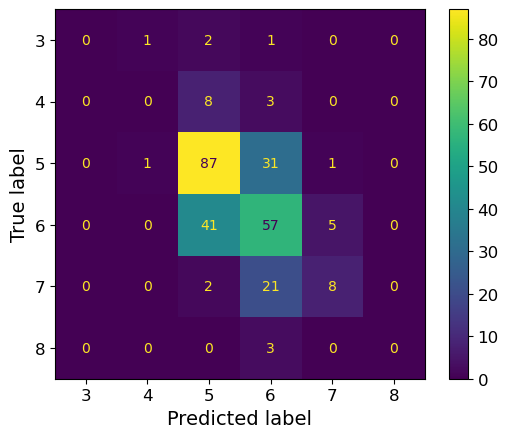

In [125]:
cm_display = ConfusionMatrixDisplay(cm_forest, display_labels= sgd_clf.classes_)
cm_display.plot()
plt.show()

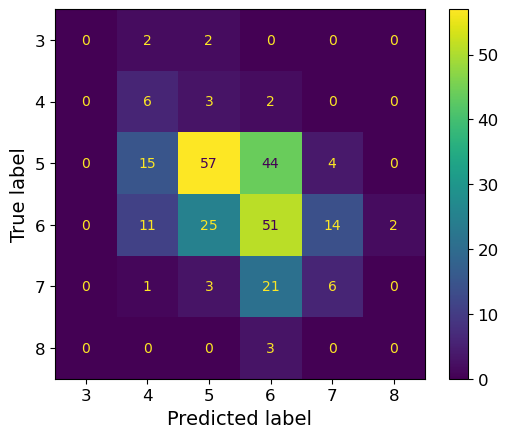

In [126]:
cm_display = ConfusionMatrixDisplay(cm_bayes, display_labels= sgd_clf.classes_)
cm_display.plot()
plt.show()